In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import itertools

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.special import expit
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from tqdm.notebook import tqdm
from datetime import datetime
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.factory import get_problem
from pymoo.optimize import minimize
#%matplotlib notebook

random_seed = 1
np.random.seed(seed=random_seed)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.join(os.getcwd(), "plot/")
today=datetime.today().strftime('%Y-%m-%d')

**Preliminaries** In the following, the classes are defined to initiate the aggregation functions $\rho_{\alpha}$ and the aggregated risk minimization (ARM) optimization for a simple 1D and 2D regression task.

In [3]:
def f_hat(experiment):
    if experiment == "1D_linear":
        f = lambda x, theta: x * theta
    elif experiment == "1D_nonlinear":
        f = lambda x, theta: np.exp(x * theta)
    if experiment == "2D_linear":
        f = lambda x, theta: (x @ theta)
    elif experiment == "2D_nonlinear":
        f = lambda x, theta: np.exp(x @ theta) 
    return f

In [4]:
class aggregation_function:
    
    """ This class aggregates the risks. """
    def __init__(self, name:str):
        """ Construct the aggregation function.
        
        Parameters
        -----------
        name : str
            the name of the function to aggregate the risks
        """       
        self.name = name
    
    def aggregate(self, risks:list, alpha:int) -> float:
            
        """Aggregates a list of risks according to an aggregation function rho. 

        Parameters
        ----------
        risks : list
        alpha : int

        Returns
        ------
        aggregated_risks : float
        
        Examples
        --------
        >>> aggregation_function(name="cvar").aggregate([1,2,3,4], 0.5)
        
        """        
        if self.name == "cvar":
            aggregated_risks = self.__cvar__(risks, alpha)
        else:
            raise NotImplementedError("Currently, only CVaR is implemented.")
        return aggregated_risks
    
    def __cvar__(self, risks:list, alpha:int) -> float:
        
        """Calculate the CVaR value for a list of risks. 

        Parameters
        ----------
        risks : list
        alpha : int

        Returns
        ------
        cvar : float
        """
        risks = np.array(risks)
        var = np.percentile(risks,alpha, method='interpolated_inverted_cdf')
        cvar = risks[risks > var].mean()
        return cvar

In [5]:
class RiskVector(ElementwiseProblem):

    def __init__(self, env_dict, alphas, fun):
        super().__init__(n_var=env_dict[0]['x'].shape[1], n_obj=len(alphas), 
                         xl=np.array([0]*env_dict[0]['x'].shape[1]), 
                         xu=np.array([1]*env_dict[0]['x'].shape[1]))
        self.env_dict = env_dict 
        self.alphas = alphas 
        self.fun = fun
    def _evaluate(self, x, out, *args, **kwargs):
        oracle = []
        for alpha in self.alphas:
            risks = [mean_squared_error(self.env_dict[e]['y'],self.fun(self.env_dict[e]['x'], x)) for e in self.env_dict.keys()]
            risks = np.array(risks)
            var = np.percentile(risks, alpha, method='interpolated_inverted_cdf')
            cvar = risks[risks > var].mean()
            oracle.append(cvar)
        out["F"]=oracle 

In [6]:
class ARM_Regression(BaseEstimator, RegressorMixin):
    def __init__(self,name,experiment="1D_linear"):
        
        """ Consutruct th aggregation function.
        
        Parameters
        -----------
        name : str
        the name of the function to aggregate the risks
        
        experiment : str, required
        the name of experimental setting
        """        
        self.experiment = experiment
    
    def pareto_front(self, f, env_dict, alphas):
        
        """Fit the coefficients of a function f. 

        Parameters
        ----------
        env_dict : dict
        alphas : list of ints 

        Returns
        ------
        coef : float
        """
        d = env_dict[0]['x'].shape[1]
        
        problem = RiskVector(env_dict, alphas, f)
        
        algorithm = NSGA2(
            pop_size=400,
            n_offsprings=10,
            sampling=FloatRandomSampling(),
            crossover=SBX(prob=0.9, eta=15),
            mutation=PM(eta=20),
            eliminate_duplicates=True
        )

        termination = get_termination("n_gen", 20)


        result = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

        return result.X

**Experiment 1** We assume the following *linear* data generation process $$Y(X) = X*\theta_{e}+\epsilon$$ and *nonlinear* data generation process $$Y(X) = sin(X*\theta_{e})+\epsilon$$.

**Experiment 1A** Assume a linear model $Y_{e}=\theta_{e}X+\epsilon$, where $X \sim \mathcal{N}(2,0.2)$ and $\epsilon\sim \mathcal{N}(0,0.1)$. We simulate different environments by drawing $\theta$ from a beta distribution $Beta(0.1,0.2)$. In total, we generate for 25 environments 100 observations each.

**Experiment 1B** Assume the same setting as in Experiment 1, however, in contrast, we simulate different environments by drawing $\theta$ from a uniform distribution $\ \mathcal{U}(0,1)$. In total, we generate for 25 environments 100 observations each.

In [7]:
class data_generator_1D:
    
    """ This class generates the 1D simulation data. """
    

    def __init__(self, num_envs = 250, size = (100,1), theta="uniform", experiment="1D_linear"):
        
        """ Construct the aggregation function.
        
        Parameters
        -----------
        experiment : str, optional
            the name of the experimental setting (whether we want f to be linear n X or non-linear)
        num_envs : int, optional
            the number of environments
        size : tuple, optional
            the size of the datset (number of observations, number of features)
        theta : str, optional
            the distrubution from which we sample the true thetas for each environment
        """
        
        self.num_envs = num_envs
        self.size = size
        self.theta = theta
        self.experiment = experiment
        self.description = f"{theta}_{experiment}"
    
    def generate(self, f) -> dict:           
        """Aggregates a list of risks. 

        Returns
        ------
        env_dict : dict
        Examples
        --------
        >>> data_generator_1D(num_envs = 250, size = (100,1), theta="uniform", experiment="1D_linear").generate()
        """
        env_list = [f'e_{i}' for i in range(1,num_envs+1,1)]
        env_dict = dict(list(enumerate(env_list)))
        for e in env_dict.keys():

            theta_true=np.random.uniform(0,1) if self.theta == "uniform" else np.random.beta(0.1,0.2)

            x=np.random.normal(loc=1, scale=0.5, size=self.size)
            noise=np.random.normal(loc=0, scale=0.05, size=self.size)
            y = f(x,theta_true)+noise

            env_dict[e] = {'x': x,'y': y,'theta_true': theta_true, 'env': [e]*size[0]}

        return env_dict

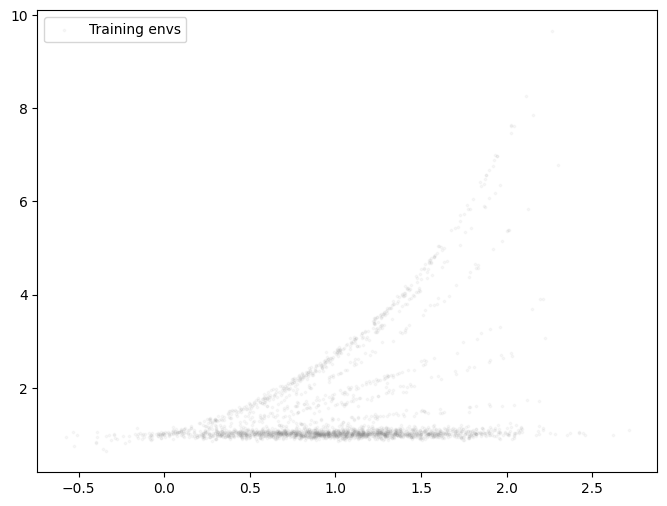

In [8]:
# Intitialize the experiment and generate the data
num_envs=25
size = (100,1)
theta="beta" 
experiment="1D_nonlinear"
rho="cvar"

f = f_hat(experiment)
data_generator = data_generator_1D(num_envs = num_envs, size = size, theta=theta, experiment=experiment)
data_dict = data_generator.generate(f).copy()

description = data_generator.description

fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict[e]['x'].ravel() for e in data_dict.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict[e]['y'] for e in data_dict.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      400 |    114 |             - |             -
     2 |      410 |    119 |  0.0011473492 |             f
     3 |      420 |    123 |  0.0017819553 |             f
     4 |      430 |    126 |  0.0023816420 |             f
     5 |      440 |    127 |  0.0033664146 |             f
     6 |      450 |    131 |  0.0002767266 |             f
     7 |      460 |    133 |  0.0003750450 |             f
     8 |      470 |    137 |  0.0005857317 |             f
     9 |      480 |    139 |  0.0006528279 |             f
    10 |      490 |    141 |  0.0006566050 |             f
    11 |      500 |    145 |  0.0012913292 |             f
    12 |      510 |    148 |  0.0013255670 |             f
    13 |      520 |    152 |  0.0204302788 |         nadir
    14 |      530 |    157 |  0.0005084484 |             f
    15 |      540 |    159 |  0.0008417904 |             f
    16 |      550 |    164 |  0.0012084360 |            

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


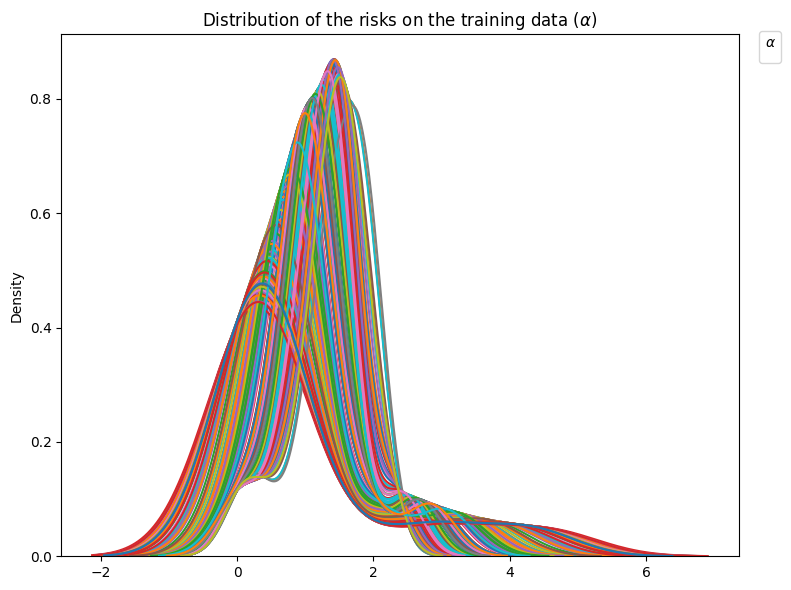

In [9]:
#Run the ARM regression task
results = pd.DataFrame(columns = ["alpha", "theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(8,6))
rg = range(5,100,5)



theta_hats = ARM_Regression(name=rho, experiment=experiment).pareto_front(f, data_dict, rg)
diverging_colors = sns.color_palette("RdBu", len(rg)*len(theta_hats))
for k, theta_hat in enumerate(theta_hats):
    risks = [mean_squared_error(data_dict[e]['y'], f(data_dict[e]['x'], theta_hat)) for e in data_dict.keys()]
    cvar_emps = np.array([aggregation_function(name="cvar").aggregate(risks, i) for i in rg])
    sns.kdeplot(risks, ax=ax)
    results.at[k, "alpha"] = (np.argmin(cvar_emps)*5+5)/100
    results.at[k, "theta_hat"] = theta_hat
    results.at[k, "cvar"] = np.max(cvar_emps)
    
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")

#norm = plt.Normalize(0.05, 0.95)
#sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
#sm.set_array([])

#ax.get_legend().remove()
#ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()
plt.savefig(path+f"{today}_{description}_risk_distribution.pdf") 

In [10]:
len(results['theta_hat'])

182

  0%|          | 0/100 [00:00<?, ?it/s]

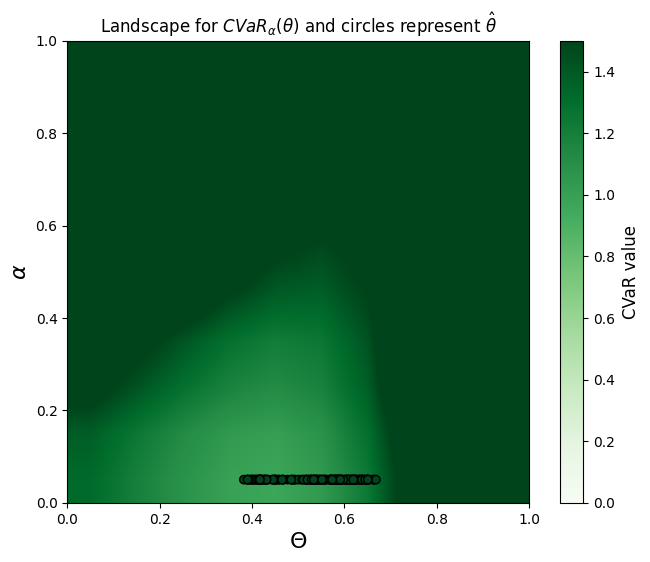

In [11]:
#Plot the CVAR landscape and the estimated thetas
step_size= 0.1
rg_alpha = np.arange(0, 1, step_size)
rg_theta = np.arange(0, 1, step_size)
output_list = list(itertools.product(*[rg_alpha, rg_theta]))

def array_for_heatmap(data_dict, alpha, theta):

    risks = [mean_squared_error(data_dict[e]['y'], f(data_dict[e]['x'], theta)) for e in data_dict.keys()]
    cvar = aggregation_function(name="cvar").aggregate(risks, alpha*100)
    
    return [np.round(alpha, 3), np.round(theta, 3), np.round(cvar, 3)]

temp = Parallel(n_jobs=8)(delayed(array_for_heatmap)(data_dict, j[0], j[1]) for j in tqdm(output_list))

# Prepare the data for the landscape plot
index, columns = np.unique([i[0] for i in temp]), np.unique([i[0] for i in temp])

landscape = pd.DataFrame(index=index, columns=columns)

for i in temp:
    landscape.at[i[0], i[1]] = float(i[2]) #if not np.nan else np.nan
    
landscape = landscape.sort_index(ascending=False).apply(pd.to_numeric, errors='coerce')

del temp


fig, ax = plt.subplots(1,1, figsize=(8,6))

vmin, vmax=0.0, 1.5

img = ax.imshow(landscape,extent=[0,1,0,1], interpolation='bilinear', cmap="Greens", vmin=vmin, vmax=vmax) #extent=[0,1,0,1]

plt.xlabel(r'$\Theta$', fontsize = 16)
plt.ylabel(r'$\alpha$', fontsize = 16)
img = ax.scatter(y=results.alpha, x=results.theta_hat, c = results.cvar, edgecolors='black', cmap = 'Greens', vmin=vmin, vmax=vmax)
ax.set_title(r"Landscape for $CVaR_{\alpha}(\theta)$ and circles represent $\hat{\theta}$")
fig.colorbar(img).set_label(label='CVaR value',labelpad=5,size=12)

plt.savefig(path+f"{today}_{description}_landscape.pdf") 

(2500, 1) (2500, 1)


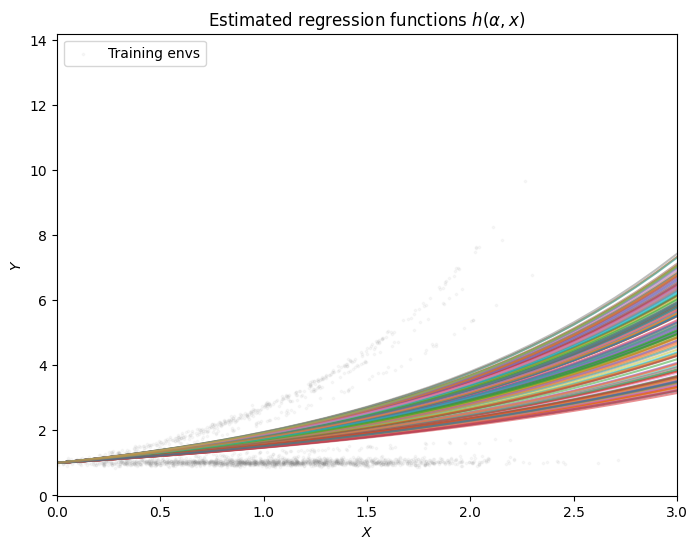

In [12]:
#Plot the data and the estimated regression function
fig, ax = plt.subplots(1,1, figsize=(8,6))

X_train = [data_dict[e]['x'].ravel() for e in data_dict.keys()]
X_train = np.array([item for sublist in X_train for item in sublist]).reshape(-1,1)
Y_train = [data_dict[e]['y'] for e in data_dict.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)
print(Y_train.shape, X_train.shape)
ax.scatter(y=Y_train, x=X_train, s=3, c="grey", alpha=0.05, label="Training envs")
ax.legend(loc='upper left')

#diverging_colors = sns.color_palette("RdBu", len(results))

for index, row in results.iterrows():
    x_plt = np.arange(0,4,0.1)
    ax.plot(x_plt, f(x_plt, row['theta_hat']), alpha=0.5, label="Test envs")

#norm = plt.Normalize(0.05, 0.95)
#sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
#sm.set_array([])

#ax.get_legend().remove()
#ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

ax.axis(xmin=0,xmax=3)
ax.axis(xmin=0,xmax=3)

ax.set_title("Generated data")
ax.set_xlabel(r"$X$")
ax.set_ylabel(r"$Y$")

ax.set_xlabel(r"$X$")
ax.set_title(r"Estimated regression functions $h(\alpha,x)$")

plt.savefig(path+f"{today}_{description}_function.pdf") 

**Experiment 2** We assume the following *linear* data generation process $$Y(X_{1},X_{2}) = X_{1}^{2}*\theta_{1,e}+X_{2}*\theta_{2,e}+\epsilon$$ and the following non-linear data generation process

$$Y(X_{1},X_{2}) = \exp^{-\sqrt{X_{1}*\theta_{1,e}+X_{2}*\theta_{2,e}}}+\epsilon$$


In [13]:
class data_generator_2D:
    
    """ This class generates the 2D simulation data. """
    

    def __init__(self, num_envs = 250, size = (100,2), experiment="linear", theta="beta"):
        
        """ Construct the aggregation function.
        
        Parameters
        -----------
        experiment : str, optional
            the name of the experimental setting (whether we want f to be linear n X or non-linear)
        num_envs : int, optional
            the number of environments
        size : tuple, optional
            the size of the datset (number of observations, number of features)
        """
        
        self.num_envs = num_envs
        self.size = size
        self.experiment = experiment
        self.description = f"{theta}_{experiment}"
        self.theta = theta 
    def generate(self, f) -> dict:
            
        """Aggregates a list of risks. 

        Returns
        ------
        env_dict : dict
        
        Examples
        --------
        >>> data_generator_2D(num_envs = 250, size = (100,2), experiment="linear").generate()
        
        """
        env_list = [f'e_{i}' for i in range(1,num_envs+1,1)]
        env_dict = dict(list(enumerate(env_list)))
        for e in env_dict.keys():

            theta_true_1 = np.random.uniform(0,1) if self.theta == "uniform" else np.random.beta(0.1,0.2)
            theta_true_2 = np.random.uniform(0,1) if self.theta == "uniform" else np.random.beta(0.1,0.2)
            theta_true = np.array([theta_true_1, theta_true_2])[:,None]
            x=np.random.normal(loc=(0,0), scale=(0.5, 0.5), size=size)
            noise=np.random.normal(loc=0, scale=0.05)
            y=f(x, theta_true)+noise
            env_dict[e] = {'x': x,'y': y,'theta_true': (theta_true_1, theta_true_2), 'env': [0]*size[0] if e < 100 else [1]*size[0]}

        return env_dict

In [14]:
# Intitialize the experiment and generate the data
num_envs=25
size = (100,2)
experiment="2D_nonlinear"
rho="cvar"

data_generator = data_generator_2D(num_envs = num_envs, size = size, experiment=experiment, theta="beta")
f = f_hat(experiment)
data_dict = data_generator.generate(f).copy()

description = data_generator.description

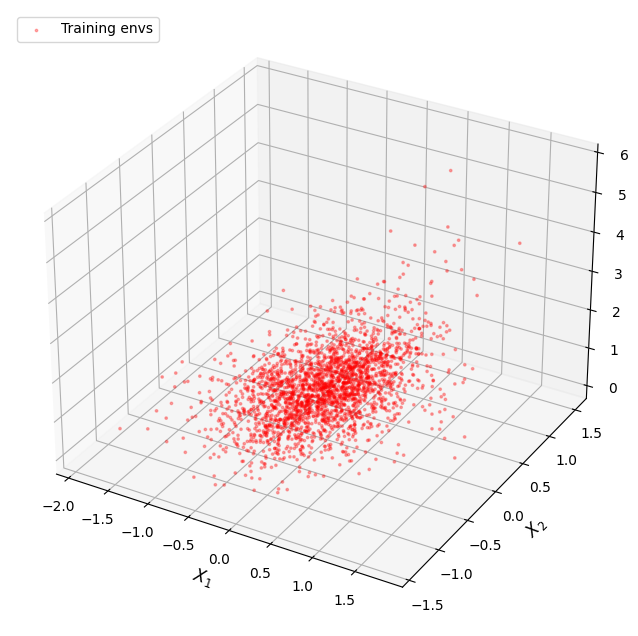

In [15]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

X_0_train = [data_dict[e]['x'][:,0:1].ravel() for e in data_dict.keys()]
X_0_train = np.array([item for sublist in X_0_train for item in sublist]).reshape(-1,1)

X_1_train = [data_dict[e]['x'][:,1:2].ravel() for e in data_dict.keys()]
X_1_train = np.array([item for sublist in X_1_train for item in sublist]).reshape(-1,1)

Y_train = [data_dict[e]['y'] for e in data_dict.keys()]
Y_train = np.array([item for sublist in Y_train for item in sublist]).reshape(-1,1)

ax.scatter(X_0_train, X_1_train, Y_train, s=3,c = "r", alpha=0.3, label="Training envs")

plt.legend(loc='upper left')

ax.set_xlabel(r"$X_1$", fontsize=12)
ax.set_ylabel(r"$X_2$", fontsize=12)
ax.set_zlabel(r"$Y$", fontsize=12)

plt.show()

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      400 |     15 |             - |             -
     2 |      410 |     15 |  0.000000E+00 |             f
     3 |      420 |     15 |  0.000000E+00 |             f
     4 |      430 |     15 |  0.000000E+00 |             f
     5 |      440 |     16 |  0.0694028802 |         ideal
     6 |      450 |     16 |  0.000000E+00 |             f
     7 |      460 |     16 |  0.0717916642 |         ideal
     8 |      470 |     17 |  0.0107973404 |             f
     9 |      480 |     17 |  0.000000E+00 |             f
    10 |      490 |     17 |  0.000000E+00 |             f
    11 |      500 |     18 |  0.0082930745 |             f
    12 |      510 |     18 |  0.000000E+00 |             f
    13 |      520 |     18 |  0.000000E+00 |             f
    14 |      530 |     18 |  0.0033261414 |             f
    15 |      540 |     18 |  0.000000E+00 |             f
    16 |      550 |     18 |  0.000000E+00 |            

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


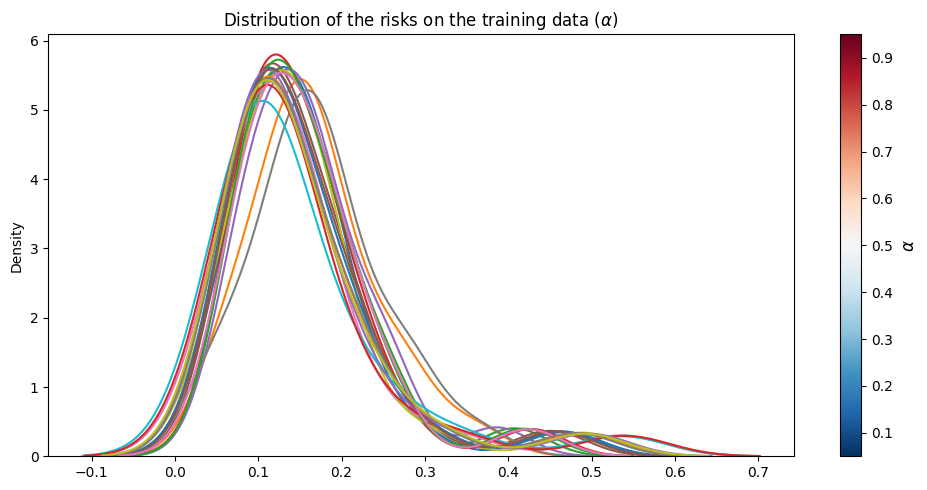

In [16]:
results = pd.DataFrame(columns = ["theta_hat", "cvar"])
fig, ax = plt.subplots(1, 1, sharey=True, figsize=(10,5))
rg = range(0,100,5)

diverging_colors = sns.color_palette("RdBu", len(rg))
theta_hats = ARM_Regression(name=rho, experiment=experiment).pareto_front(f, data_dict, rg)
diverging_colors = sns.color_palette("RdBu", len(rg)*len(theta_hats))
for k, theta_hat in enumerate(theta_hats):
    risks = [mean_squared_error(data_dict[e]['y'], f(data_dict[e]['x'], theta_hat)) for e in data_dict.keys()]
    cvar_emps = np.array([aggregation_function(name="cvar").aggregate(risks, i) for i in rg])
    sns.kdeplot(risks, ax=ax)
    results.at[k, "theta_hat"] = theta_hat
    results.at[k, "cvar"] = np.max(cvar_emps)
ax.legend(bbox_to_anchor=(1.02, 1.02), title=r"$\alpha$", loc='upper left')
ax.set_title(r"Distribution of the risks on the training data ($\alpha$)")

norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)

sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm).set_label(label= r'$\alpha$',labelpad=5,size=12)

plt.tight_layout()

(900, 2)


Text(0.5, 0, '$Y$')

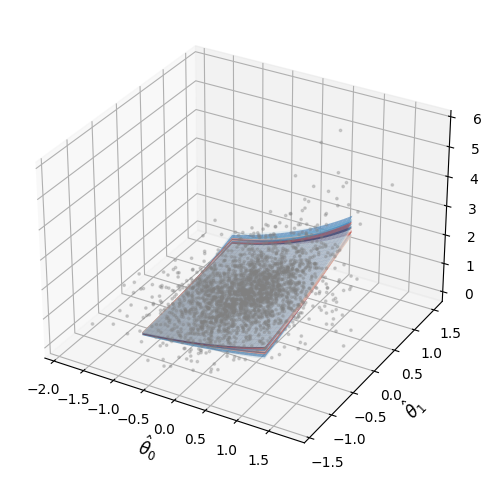

In [17]:
x = np.linspace(-1, 1, 30)
y = np.linspace(-1, 1, 30)

X, Y = np.meshgrid(x, y)
print(np.concatenate((X.reshape(-1,1),Y.reshape(-1,1)),axis=1).shape)

fig = plt.figure(figsize=(8,6))
ax = plt.axes(projection='3d')
diverging_colors = sns.color_palette("RdBu", len(results))
j=1
for index, row in results.iterrows():
    Z = f(np.concatenate((X.reshape(-1,1), Y.reshape(-1,1)), axis=1), row['theta_hat']).reshape(30,30)
    ax.plot_surface(X, Y, Z, color = diverging_colors[len(results)-j], alpha=0.5)
    j+=1


norm = plt.Normalize(0.05, 0.95)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
sm.set_array([])

ax.scatter(X_0_train, X_1_train, Y_train, c = "grey", s=3, alpha=0.3, label="Training envs")

divider = make_axes_locatable(ax)

ax.set_xlabel(r"$\hat{\theta}_{0}$", fontsize=12)
ax.set_ylabel(r"$\hat{\theta}_{1}$", fontsize=12)
ax.set_zlabel(r"$Y$", fontsize=12)

Text(0.5, 1.0, 'Multi Objective Optimization')

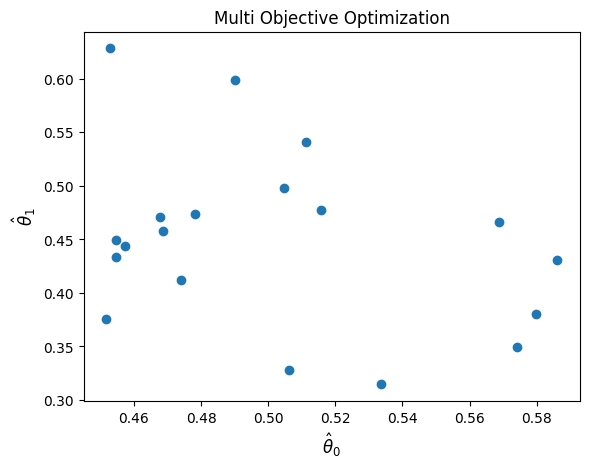

In [18]:
theta_hat_0 = [results['theta_hat'][key][0] for key in range(len(theta_hats))]
theta_hat_1 = [results['theta_hat'][key][1] for key in range(len(theta_hats))]
sc=plt.scatter(theta_hat_0, theta_hat_1)
plt.xlabel(r"$\hat{\theta}_{0}$", fontsize=12)
plt.ylabel(r"$\hat{\theta}_{1}$", fontsize=12)
plt.title("Multi Objective Optimization")